In [1]:
!pip install opendatasets --upgrade --quiet

In [2]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: rimoghosh
Your Kaggle Key: ··········


100%|██████████| 395M/395M [00:19<00:00, 21.1MB/s]


In [3]:
import os
data_dir='./animefacedataset'
print(os.listdir(data_dir))

['images']


In [4]:
print(os.listdir(data_dir+'/images')[:10])

['21451_2008.jpg', '62567_2019.jpg', '59126_2018.jpg', '52285_2015.jpg', '6298_2003.jpg', '25802_2009.jpg', '42264_2013.jpg', '9071_2004.jpg', '43543_2013.jpg', '2244_2001.jpg']


In [5]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T


In [6]:
image_size=64
batch_size=128
stats=(0.5,0.5,0.5),(0.5,0.5,0.5)

In [7]:
train_ds=ImageFolder(data_dir,transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)
]))
train_dl=DataLoader(train_ds,batch_size,shuffle=True,num_workers=3,pin_memory=True)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [8]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [9]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

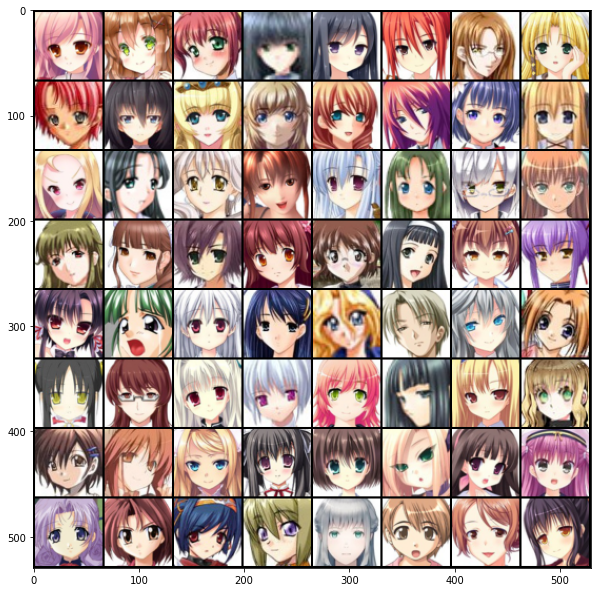

In [10]:
def show_images(images,nmax=64):
  fig,ax=plt.subplots(figsize=(10,12))
  # ax.set_xticks([])
  # ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]),n_row=8).permute(1,2,0))

def show_batch(dl,nmax=64):
  for images,_ in dl:
    show_images(images,nmax)
    break

show_batch(train_dl,nmax=64)


In [11]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [12]:
device=get_default_device()
device

device(type='cuda')

In [13]:
train_dl=DeviceDataLoader(train_dl,device)

## Discriminator Network

The discriminator takes an image as input, and tries to classify it as "real" or "generated". In this sense, it's like any other neural network. We'll use a convolutional neural networks (CNN) which outputs a single number output for every image. We'll use stride of 2 to progressively reduce the size of the output feature map.

![](https://github.com/vdumoulin/conv_arithmetic/raw/master/gif/padding_strides_odd.gif)

In [14]:
import torch.nn as nn

In [15]:
discriminator=nn.Sequential(
    # 3 x 64 x 64
    nn.Conv2d(3,64,kernel_size=4,padding=1,stride=2,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),
    # 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # 512 x 4 x 4
    
    nn.Conv2d(512,1,kernel_size=4, stride=1, padding=0, bias=False),

    # 512 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid()

)

## Generator Network

The input to the generator is typically a vector or a matrix of random numbers (referred to as a latent tensor) which is used as a seed for generating an image. The generator will convert a latent tensor of shape `(128, 1, 1)` into an image tensor of shape `3 x 28 x 28`. To achive this, we'll use the `ConvTranspose2d` layer from PyTorch, which is performs to as a *transposed convolution* (also referred to as a *deconvolution*). [Learn more](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md#transposed-convolution-animations)

![](https://i.imgur.com/DRvK546.gif)

In [16]:
latent_size=128

In [17]:
generator=nn.Sequential(
    # latent_size x 1 x 1
    nn.ConvTranspose2d(latent_size,512,kernel_size=4, stride=1,padding=0,bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # 512 x 4 x 4

    nn.ConvTranspose2d(512,256,kernel_size=4, stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # 256 x 8 x 8

    nn.ConvTranspose2d(256,128,kernel_size=4, stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # 128 x 16 x 16

    nn.ConvTranspose2d(128,64,kernel_size=4, stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # 64 x 32 x 32 

    nn.ConvTranspose2d(64,3,kernel_size=4, stride=2,padding=1,bias=False),
    nn.Tanh(),
    # 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


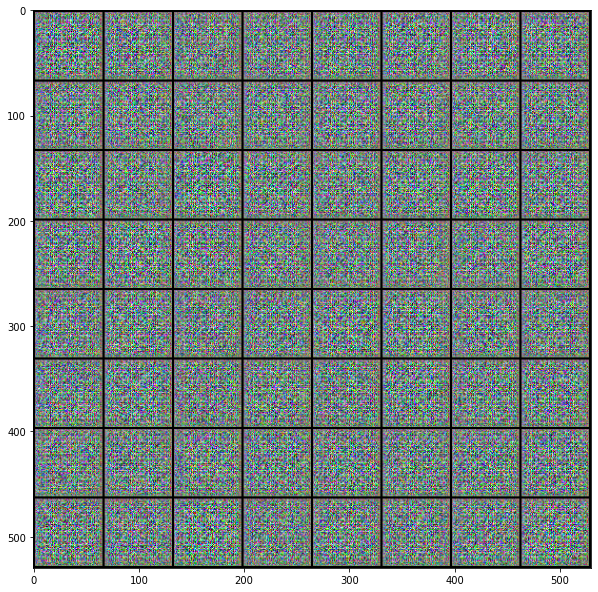

In [18]:
xb=torch.randn(batch_size,latent_size,1,1)
fake_images=generator(xb)
print(fake_images.shape)
show_images(fake_images)


In [19]:
discriminator=to_device(discriminator,device)
generator=to_device(generator,device)

In [20]:
discriminator

Sequential(
  (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2, inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2, inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): LeakyReLU(negative_slope=0.2, inplace=True)
  (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): LeakyReLU(negative_slope=0.2, inplace=True)
  (12): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (13): Flatten(s

In [21]:
generator

Sequential(
  (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): ReLU(inplace=True)
  (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (13): Tanh()
)

## Discriminator Training

Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

<img src="https://image.slidesharecdn.com/chrishokamp-dublinnlp3-160805110319/95/task-based-learning-for-nlp-going-beyond-cross-entropy-chris-hokamp-10-638.jpg?cb=1470395213" width="420" >

In [22]:
import torch.nn.functional as F

In [23]:
def train_discriminator(real_images,opt_d):
  # Clear discriminator gradients
  opt_d.zero_grad()
  
  # Pass Real Images to discriminator
  real_preds=discriminator(real_images)
  real_targets= torch.ones(real_images.size(0),1,device=device)
  real_loss=F.binary_cross_entropy(real_preds,real_targets)
  real_score=torch.mean(real_targets).item()

  # Generate Fake Images
  latent=torch.randn(batch_size,latent_size,1,1, device=device)
  fake_images= generator(latent)

  # Pass fake images through discriminator
  fake_targets= torch.zeros(fake_images.size(0),1,device=device)
  fake_preds=discriminator(fake_images)
  fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
  fake_score=torch.mean(fake_preds).item()

  # Update discriminator weights
  loss = real_loss + fake_loss
  loss.backward()
  opt_d.step()

  return loss.item(),real_score,fake_score

Here are the steps involved in training the discriminator.

- We expect the discriminator to output 1 if the image was picked from the real MNIST dataset, and 0 if it was generated using the generator network. 

- We first pass a batch of real images, and compute the loss, setting the target labels to 1. 

- Then we pass a batch of fake images (generated using the generator) pass them into the discriminator, and compute the loss, setting the target labels to 0. 

- Finally we add the two losses and use the overall loss to perform gradient descent to adjust the weights of the discriminator.

It's important to note that we don't change the weights of the generator model while training the discriminator (`opt_d` only affects the `discriminator.parameters()`)

In [24]:
def train_generator(opt_g):
  opt_g.zero_grad()

  # Generate fake images
  latent=torch.randn(batch_size,latent_size,1,1,device=device)
  fake_images=generator(latent)

  # Try to fool the discriminator
  preds=discriminator(fake_images)
  targets=torch.ones(batch_size,1,device=device)
  loss=F.binary_cross_entropy(preds,targets)

  # Update generator weights
  loss.backward()
  opt_g.step()

  return loss.item()

In [25]:
from torchvision.utils import save_image

In [26]:
sample_dir='generated'
os.makedirs(sample_dir,exist_ok=True)

In [27]:
def save_samples(index,latent_tensors,show=True):
  fake_images=generator(latent_tensors)
  fake_fname='generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images),os.path.join(sample_dir,fake_fname),nrow=8)
  print('Saving',fake_fname)
  if show:
    fig,ax=plt.subplots(figsize=(8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [28]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


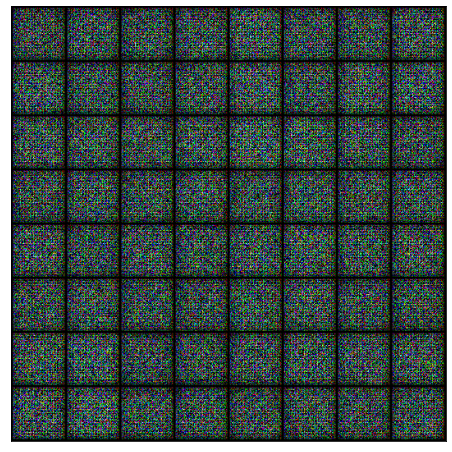

In [29]:
save_samples(0, fixed_latent)

## Full Training Loop

Let's define a `fit` function to train the discriminator and generator in tandem for each batch of training data. We'll use the Adam optimizer with some custom parameters (betas) that are known to work well for GANs. We will also save some sample generated images at regular intervals for inspection.

<img src="https://i.imgur.com/6NMdO9u.png" style="max-width:420px; margin-bottom:32px"/>



In [30]:
from tqdm.notebook import tqdm


In [31]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [32]:
lr=0.0002
epochs=25

In [33]:
history=fit(epochs,lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 7.0477, loss_d: 0.5341, real_score: 1.0000, fake_score: 0.0052
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 5.9103, loss_d: 0.3331, real_score: 1.0000, fake_score: 0.2228
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 3.7764, loss_d: 0.0827, real_score: 1.0000, fake_score: 0.0452
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 8.6331, loss_d: 0.0558, real_score: 1.0000, fake_score: 0.0031
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 14.8332, loss_d: 0.7348, real_score: 1.0000, fake_score: 0.4317
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 5.3559, loss_d: 0.1244, real_score: 1.0000, fake_score: 0.0510
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 7.3427, loss_d: 0.1375, real_score: 1.0000, fake_score: 0.0738
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 8.4314, loss_d: 0.1864, real_score: 1.0000, fake_score: 0.1314
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 5.7968, loss_d: 0.0569, real_score: 1.0000, fake_score: 0.0128
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 8.8490, loss_d: 0.1745, real_score: 1.0000, fake_score: 0.1147
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 5.9481, loss_d: 0.0777, real_score: 1.0000, fake_score: 0.0240
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 7.0991, loss_d: 0.0493, real_score: 1.0000, fake_score: 0.0216
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 12.9445, loss_d: 0.0684, real_score: 1.0000, fake_score: 0.0005
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 8.8222, loss_d: 0.0446, real_score: 1.0000, fake_score: 0.0095
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 10.1563, loss_d: 0.0998, real_score: 1.0000, fake_score: 0.0035
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 5.3289, loss_d: 0.1177, real_score: 1.0000, fake_score: 0.0366
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 6.3196, loss_d: 0.0488, real_score: 1.0000, fake_score: 0.0271
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 6.7035, loss_d: 0.0580, real_score: 1.0000, fake_score: 0.0065
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 5.2149, loss_d: 0.0658, real_score: 1.0000, fake_score: 0.0239
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 6.7603, loss_d: 0.0461, real_score: 1.0000, fake_score: 0.0391
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 6.0241, loss_d: 0.0363, real_score: 1.0000, fake_score: 0.0036
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 9.8741, loss_d: 0.0970, real_score: 1.0000, fake_score: 0.0006
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 5.0087, loss_d: 0.1196, real_score: 1.0000, fake_score: 0.0277
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 3.9689, loss_d: 2.4494, real_score: 1.0000, fake_score: 0.0000
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 6.7696, loss_d: 0.0662, real_score: 1.0000, fake_score: 0.0068
Saving generated-images-0025.png


In [34]:
losses_d,losses_g,real_scores,fake_scores=history

In [34]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [36]:
from IPython.display import Image

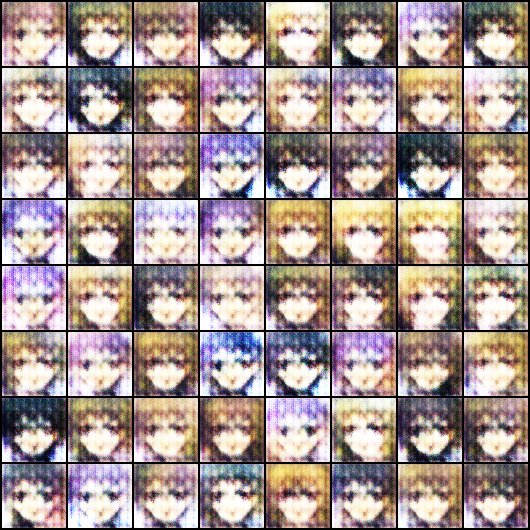

In [37]:
Image('./generated/generated-images-0001.png')

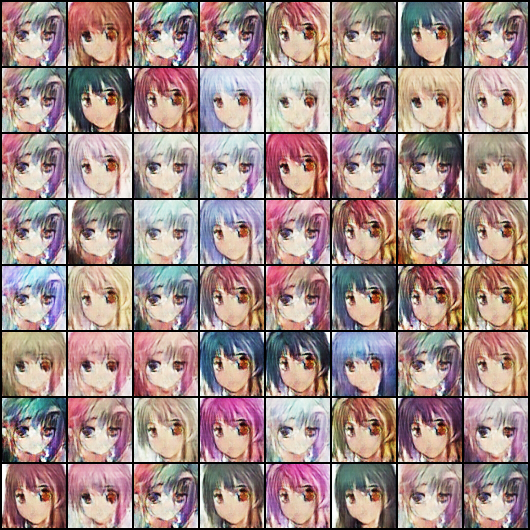

In [38]:
Image('./generated/generated-images-0021.png')

In [39]:
import cv2
import os
vid_fname= 'gans_training.avi'
files=[os.path.join(sample_dir,f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out=cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'),1,(530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

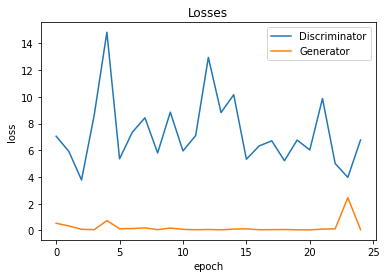

In [40]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

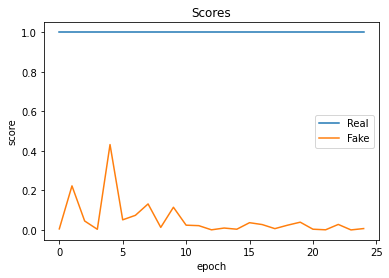

In [41]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');